In [312]:
import os, os.path
import numpy as np
import pandas as pd
import data_structures as ds
import setup_analysis as sa
import support_functions as sf
import importlib
import itertools
import time
import warnings
import matplotlib.pyplot as plt
import model_afolu as ma
import model_circular_economy as mc
import model_ippu as mi
import model_socioeconomic as ms
import scipy.optimize as sco 

importlib.reload(ds)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(ms)

<module 'model_socioeconomic' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_socioeconomic.py'>

In [121]:
# read in FAOSTAT DATA - note, the file encoding in encode is needed to read in FAOSTAT datasets
encode = "ISO-8859-1"
df_land_use = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Inputs_LandUse_E_All_Data_(Normalized)/Inputs_LandUse_E_All_Data_(Normalized).csv", encoding = encode)
df_land_cover = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Environment_LandCover_E_All_Data_(Normalized)/Environment_LandCover_E_All_Data_(Normalized).csv", encoding = encode)
df_land_use_emit = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Emissions_Land_Use_Forests_E_All_Data_(Normalized)/Emissions_Land_Use_Forests_E_All_Data_(Normalized).csv", encoding = encode)

# get base transition matrices from Costa Rica
df_base_transitions = pd.read_excel(
    "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/dev/fake_data/land_use_transition_baseline_assumption_fake_data.xlsx",
    sheet_name = "data_sheet"
)
df_base_transitions.sort_values(by = ["year", "scen", "cat"], inplace = True)
# categories in the transition dataset
cats_transition_template = [x for x in df_base_transitions.columns if (x not in ["year", "scen", "cat"])]
cats_transition_template.sort()
# transition matrices
array_base = np.array(df_base_transitions[df_base_transitions["scen"] == "bau"][cats_transition_template])
array_fut = np.array(df_base_transitions[df_base_transitions["scen"] == "ndp_nominal"][cats_transition_template])

In [790]:

# renaming for 
dict_item_rnm_lu = {
    6620: "croplands",
    6717: "forests_primary",
    6716: "forests_secondary",
    6655: "grasslands",
    6670: "all_other"
}

dict_item_rnm_lc = {
    6970: "settlements",
    6975: "forests_mangroves",
    6976: "other",
    6977: "wetlands",
    6978: "other",
    6979: "other",
    6980: "other"
}

def get_areas_by_sisepuede_category(
    df_lc: pd.DataFrame,
    df_lu: pd.DataFrame,
    dict_item_rnm_lc: dict, 
    dict_item_rnm_lu: dict,
    country: str,
    year: int,
    cat_all_other: str = "all_other",
    element_keep: str = "Area",
    field_area: str = "Area",
    field_element: str = "Element",
    field_item_code: str = "Item Code",
    field_new_cat: str = "category",
    field_unit: str = "Unit",
    field_value: str = "Value", 
    field_year: str = "Year",
    unit_keep: str = "1000 ha"
) -> pd.DataFrame:
    
    fields_ext = [field_year, field_value, field_new_cat]
    
    dicts_out = {
        "lu": {"df": df_lu, "dict": dict_item_rnm_lu},
        "lc": {"df": df_lc, "dict": dict_item_rnm_lc}
    }
    # land use component
    for df_nm in ["lu", "lc"]:
        
        df = dicts_out[df_nm]["df"]
        dict_repl = dicts_out[df_nm]["dict"]
        
        df_merge = df[
            df[field_area].isin([country]) &
            df[field_unit].isin([unit_keep]) &
            df[field_year].isin([year])
        ]
        df_merge = df_merge[df_merge[field_item_code].isin(dict_repl.keys())]
        df_merge[field_new_cat] = np.array(df_merge[field_item_code].replace(dict_repl))
        df_merge.dropna(subset = [field_value], inplace = True)
        
        # aggregate by item code
        if df_nm == "lc":
            fields_grp = [field_year, field_new_cat, field_item_code]
            fields_agg = [field_value]
            dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
            dict_agg.update(dict(zip(fields_agg, ["mean" for x in fields_agg])))
            df_merge = df_merge.groupby(fields_grp).agg(dict_agg).reset_index(drop = True)
            
            # get sum
            fields_grp = [field_year, field_new_cat]
            fields_agg = [field_value]
            dict_agg = dict(zip(fields_grp, ["first" for x in fields_grp]))
            dict_agg.update(dict(zip(fields_agg, ["sum" for x in fields_agg])))
            df_merge.drop([field_item_code], axis = 1, inplace = True)
            df_merge = df_merge.groupby(fields_grp).agg(dict_agg).reset_index(drop = True)
            
        df_merge = df_merge[fields_ext].reset_index(drop = True)
        dicts_out[df_nm].update({"df_clean": df_merge})
    
    # some other cleaning
    df_lc = dicts_out["lc"]["df_clean"]
    df_lu = dicts_out["lu"]["df_clean"]
    field_tmp_cat = f"{field_new_cat}_new"
    # update lc
    total_lc = np.sum(np.array(df_lc[field_value]))
    frac_lc = np.array(df_lc[field_value])/total_lc
    df_lc["frac_cat"] = frac_lc
    df_lc[field_tmp_cat] = np.array(df_lc[field_new_cat])
    df_lc[field_new_cat] = cat_all_other
    df_lc.drop([field_value], axis = 1, inplace = True)
    
    # update lu
    df_lu["frac_cat"] = 1.0
    df_lu[field_tmp_cat] = np.array(df_lu[field_new_cat])
    
    df_lu_not_other = df_lu[df_lu[field_new_cat] != cat_all_other].copy()
    df_lu_other = df_lu[df_lu[field_new_cat] == cat_all_other].copy()
    df_lu_other = df_lu_other[[field_year, field_value, field_new_cat]]
    df_lu_other = pd.merge(df_lc, df_lu_other, how = "left")
    
    df_total_lu = pd.concat([df_lu_not_other, df_lu_other], axis = 0).reset_index(drop = True)
    
    df_total_lu["area"] = np.array(df_total_lu[field_value])*np.array(df_total_lu["frac_cat"])
    df_total_lu = df_total_lu[[field_year, field_tmp_cat, "area"]]
    df_total_lu.rename(columns = {field_year: "year", field_tmp_cat: "category"}, inplace = True)
    #return dicts_out["lc"]["df_clean"], dicts_out["lu"]["df_clean"]

    return df_total_lu

df_tmp = get_areas_by_sisepuede_category(
    df_land_cover, 
    df_land_use, 
    dict_item_rnm_lc,
    dict_item_rnm_lu,
    "Brazil", 2018
)


# specify FAOSTAT Land Cover and Land Use dataset, dictionary categories, country, and year to get data frame wide by year
def get_areas_by_sisepuede_category_wide_by_year(
    df_lc: pd.DataFrame,
    df_lu: pd.DataFrame,
    dict_item_rnm_lc: dict, 
    dict_item_rnm_lu: dict,
    country: str,
    years: list,
    **kwargs
):
    
    df_out = pd.DataFrame()
    for year in years:
        df_tmp = get_areas_by_sisepuede_category(
            df_lc, 
            df_lu, 
            dict_item_rnm_lc,
            dict_item_rnm_lu,
            country, year
        )
        
        df_tmp.rename(columns = {"area": f"year_{year}"}, inplace = True)
        df_tmp = df_tmp[[x for x in df_tmp.columns if (x != "year")]]
        df_out = df_tmp if (len(df_out) == 0) else pd.merge(df_out, df_tmp)
    
    df_out = df_out.sort_values(by = ["category"]).reset_index(drop = True)

    return df_out



years_run = list(range(2000, 2019))
df_tmp = get_areas_by_sisepuede_category_wide_by_year(
    df_land_cover, 
    df_land_use, 
    dict_item_rnm_lc,
    dict_item_rnm_lu,
    "Argentina",
    years_run
)



<AxesSubplot:xlabel='year'>

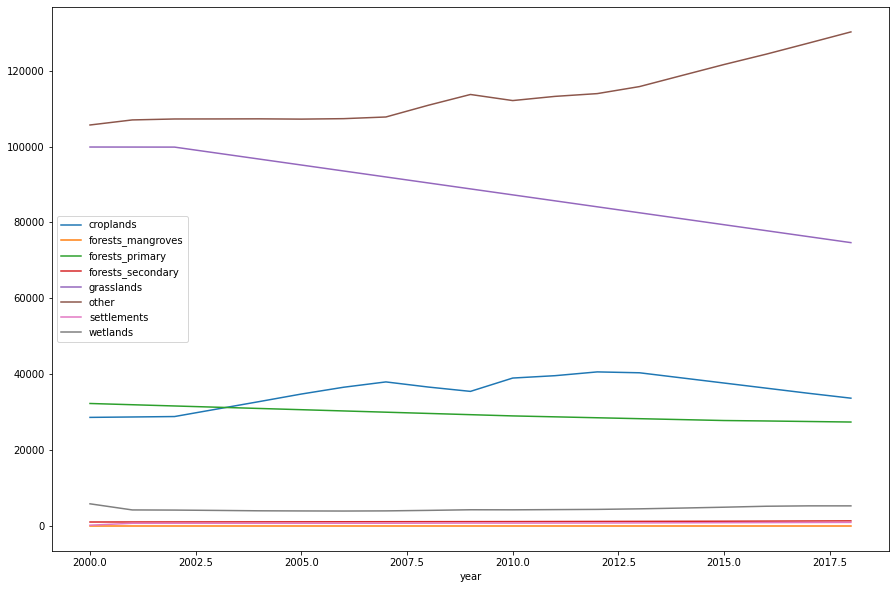

In [809]:
#df_tmp#[[x for x in df_tmp.columns if x != "category"]]#.sum(axis = 0)
nms = list(df_tmp["category"])
dict_rename = dict(zip(range(len(nms)), nms))
dict_rename.update({"index": "year"})
df_tmp2 = df_tmp.transpose().reset_index().rename(columns = dict_rename)
df_tmp2 = df_tmp2.iloc[1:]
df_tmp2["year"] = [int(x.replace("year_", "")) for x in list(df_tmp2["year"])]

fig, ax = plt.subplots(figsize = (15, 10))
df_tmp2.plot(x = "year", ax = ax)


In [823]:
def format_transition_matrix_as_df(Q: np.ndarray, cats: list) -> pd.DataFrame:
    # build dataframe
    df_out = np.array([Q.flatten("C")])
    fields_out = [f"{x[0]}_to_{x[1]}" for x in itertools.product(cats, cats)]
    df_out = pd.DataFrame(df_out, columns = fields_out)
    return df_out

##  one approach -- use a linear program to get a palattable transition matrix
def solve_transition(
    v0: np.ndarray,
    v1: np.ndarray,
    array_template: np.ndarray, 
    cats: list,
    max_trans_prob: float = 0.998,
    min_trans_prob: float = 0.0001,
    dict_bound_by_node: dict = None,
    default_min: float = 0.96,
    optimization_approach: str = "min_diagonal",
    solver = "revised simplex"
):
    
    inds = np.where(array_template > 0)
    row_inds, col_inds = inds

    ##  equality components

    # vector multiplication
    A_eq_p1 = np.zeros((len(v1), len(row_inds)))
    b_eq_p1 = v1
    # rows sum to 1
    A_eq_p2 = np.zeros((len(v0), len(row_inds)))
    b_eq_p2 = np.ones(len(v0))


    ##  inequality components

    # minimum values 
    A_leq_p1 = np.zeros((len(v0), len(row_inds)))
    b_leq_p1 = np.zeros(len(v0))
    dict_bounds = {} if (dict_bound_by_node is None) else dict_bound_by_node
    # get any non-diagonal elements
    nodes_non_diag = [k for k in dict_bounds.keys() if k[0] != k[1]]
    A_leq_p2 = np.zeros((len(nodes_non_diag), len(row_inds)))
    b_leq_p2 = np.zeros(len(nodes_non_diag))
    
    # initizlize objective
    c = np.zeros(len(row_inds))
    
    # loop over number of states to start with to set constraints on diagonal elements
    for i in enumerate(v0):
        i, const = i
        for j in range(len(row_inds)):
            row = row_inds[j]
            col = col_inds[j]
            
            # matrix multiplication constraint
            A_eq_p1[i, j] = v0[row] if (col == i) else 0.0
            # row summation constraint
            A_eq_p2[i, j] = 1.0 if (row == i) else 0.0
            # add minimum values for diagonals only
            if (row == col) and (row == i):
                if ((row, col) in dict_bounds.keys()):
                    bound, orientation = dict_bounds[(row, col)]
                    # lower bound
                    if orientation == ">":
                        A_leq_p1[i, j] = -1 
                        b_leq_p1[i] = -bound
                    # upper bound
                    elif orientation == "<":
                        A_leq_p1[i, j] = 1 
                        b_leq_p1[i] = bound
                        
                        print(bound)
                else:
                    A_leq_p1[i, j] = -1 
                    b_leq_p1[i] = -default_min
            # current objective: minimize diagonal
            if i == 0:
                if optimization_approach == "min_diagonal":
                    # minimize the diagonal subject to some minimal values
                    c[j] = 1.0 if (row == col) else 0.0
                elif optimization_approach == "max_diagonal":
                    # maximize the diagonal subjecto to some minimal values elsewhere 
                    c[j] = -1.0 if (row == col) else 0.0

    # add any non-diagonal minimums
    for i in enumerate(nodes_non_diag):
        i, const = i
        for j in range(len(row_inds)):
            row = row_inds[j]
            col = col_inds[j]
            # add minimum values for non-diagonals
            if ((row, col) in dict_bounds.keys()) and (row == i) and (row != col):
                bound, orientation = dict_bounds[(row, col)]
                # lower bound
                if orientation == ">":
                    A_leq_p2[i, j] = -1 
                    b_leq_p2[i] = -bound
                # upper bound
                elif orientation == "<":
                    A_leq_p2[i, j] = 1 
                    b_leq_p2[i] = bound

    # setup matrices - leq and eq
    A_leq = np.concatenate([A_leq_p1, A_leq_p2])
    b_leq = np.concatenate([b_leq_p1, b_leq_p2])
    A_eq = np.concatenate([A_eq_p1, A_eq_p2])
    b_eq = np.concatenate([b_eq_p1, b_eq_p2])
    
    global c_out
    global A_leq_out
    global b_leq_out
    global A_eq_out
    global b_eq_out
    
    c_out = c
    A_leq_out = A_leq
    b_leq_out = b_leq
    A_eq_out = A_eq
    b_eq_out = b_eq
    
    # get results
    vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})

    # get transition matrix
    Q = np.zeros((len(v0), len(v0)))
    np.put(Q, inds[0]*len(v0) + inds[1], vec.x)
    # build dataframe
    df_out = format_transition_matrix_as_df(Q, cats)
    
    return Q, df_out


def get_transition_component(
    df_areas_wide_by_year: pd.DataFrame,
    matrix_transition_template: np.ndarray,
    cats_ordered: list,
    field_category: str = "category",
    field_prepend_year: str = "year_",
    field_year: str = "year",
    solution_error_thresh: float = 0.000001,
    max_trans_prob: float = 0.998,
    min_trans_prob: float = 0.0001,
    dict_bound_by_node: dict = None, 
    default_min: float = 0.96,
    optimization_approach: str = "min_diagonal",
    solver: str = "revised simplex"
):
    # initialize categories and available years
    cats_avail = list(df_areas_wide_by_year[field_category])
    years_avail_fields = [x for x in df_areas_wide_by_year.columns if (field_prepend_year in x)]
    years_avail = [int(x.replace(field_prepend_year, "")) for x in years_avail_fields]
    dict_ya_to_yaf = dict(zip(years_avail, years_avail_fields))
    dict_yaf_to_ya = dict(zip(years_avail_fields, years_avail))
    years_avail_sort = sorted(years_avail)
    # intialize
    ords = [cats_avail.index(cat) for cat in cats_ordered]
    df_areas = df_areas_wide_by_year.copy()
    df_areas = df_areas.loc[ords].reset_index(drop = True)
    
    # initialize outputs
    df_out = []
    Q_0 = 0.0
    count_Q = 0
    diagnostic_list = []
    
    min_error = 1
    for ind in range(len(years_avail_sort) - 1):
        y0 = years_avail_sort[ind]
        y1 = years_avail_sort[ind + 1]
        y0_field = dict_ya_to_yaf[y0]
        y1_field = dict_ya_to_yaf[y1]

        v0 = np.array(df_areas[y0_field])
        v1 = np.array(df_areas[y1_field])
        
        # try a few orientations
        design_try = [
            (dict_bound_by_node, default_min, optimization_approach),
            #({}, default_min, optimization_approach),
            #(dict_bound_by_node, default_min**2, optimization_approach)
            #({}, default_min**2, optimization_approach)
        ]
        
        i = 0
        error_val = solution_error_thresh*2 + 0.01
        Q = 0.0
        
        # loop over design elements to try
        while (error_val > solution_error_thresh) and i < len(design_try):
            
            try:
                Q, df_transitions = solve_transition(
                    v0, 
                    v1, 
                    matrix_transition_template, 
                    cats_ordered, 
                    max_trans_prob = max_trans_prob,
                    min_trans_prob = min_trans_prob,
                    dict_bound_by_node = design_try[i][0], 
                    default_min = design_try[i][1],
                    optimization_approach = design_try[i][2],
                    solver = solver
                )
                error_val = np.linalg.norm(np.dot(v0, Q) - v1)/np.linalg.norm(v1)
                # correct and normalize
                Q = sf.vec_bounds(Q, (0, 1))
                Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()
            except:
                warnings.warn(f"Warning: solution infeasible. Resetting error.")
                error_val = solution_error_thresh*2 + 0.01
            
            i += 1
        
        # some updates to find best year in case nothing is used
        diagnostic_list.append((y0, i - 1))
        if np.sum(Q) > 0:
            if ind == 0:
                min_error = error_val
                min_error_q, min_error_df, min_error_y = Q, df_transitions, y0
            elif error_val < min_error:
                min_error = error_val
                min_error_q, min_error_df, min_error_y = Q, df_transitions, y0
        
            # add to output mean 
            if (error_val < solution_error_thresh):
                print(f"In year {y0}, found acceptable solution on design {i - 1}")
                Q_0 += Q
                count_Q += 1
                df_transitions[field_year] = y0
                df_out.append(df_transitions)
    
    # if no options were selected
    if len(df_out) == 0:
        Q_0 = min_error_q
        count_Q = 1
        df_transitions = min_error_df
        df_transitions[field_year] = min_error_y
        df_out.append(df_transitions)
        print(f"\tNo options found. Assigning best fit from year {min_error_y} with error {min_error}")
            
    # update mean
    if (count_Q > 0):
        Q_0 = Q_0/count_Q if (count_Q > 0) else Q_0
        df_mean = format_transition_matrix_as_df(Q_0, cats_ordered)
        df_out = pd.concat(df_out, axis = 0)
    
        return df_out, df_mean, diagnostic_list
    else:
        return None, None, diagnostic_list


df_out, df_mean, diagnostic_list = get_transition_component(
    df_tmp,
    array_base,#np.ones(array_base.shape),
    cats_transition_template,
    min_trans_prob = 0.0,
    dict_bound_by_node = {
        (0, 5): (0.01, "<"),
        # forest mangroves to forest mangroves
        (1, 1): (0.9, ">"),
        # primary forests to primary forests
        (2, 2): (0.98, ">"),
        # secondary forests to secondary forests
        #(3, 3): 0.9,
        # other lands
        (5, 5): (0.8, ">"),
        # settlements to settlements
        (6, 6): (0.99, ">")

    },
    optimization_approach = "max_diagonal",
    default_min = 0.96
    
)


In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0


<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In [824]:
# setup run over all countries
all_countries = set(sa.model_attributes.dict_attributes["region"].table["category_name"])
countries = set(df_land_cover["Area"]) & set(df_land_use["Area"]) & all_countries
countries = countries | set({"Bolivia (Plurinational State of)", "Venezuela (Bolivarian Republic of)"})

# get 20 years of data
years_run = list(range(1999, 2019))

# initialize output
df_all_transitions_out = []
df_mean_transition_out = []

# functio to reformat the country name for integration
def format_country_name(country: str) -> str:
    country_out = country.split("(")[0].strip().lower().replace(" ", "_")
    return country_out

# specify different minimum values by approach t
dict_bounds_by_approach = {
    "min_diagonal": {
        "node_minima": {
            # cropland to other
            (0, 5): (0.005, "<"),
            # forest mangroves to forest mangroves
            (1, 1): (0.97, ">"),
            # primary forests to primary forests
            (2, 2): (0.985, ">"),
            # grasslands to other
            (4, 5): (0.005, "<"),
            # other lands
            (5, 5): (0.8, ">"),
            # settlements to settlements
            (6, 6): (0.98, ">"),
            # wetlands to wetlands
            (7, 7): (0.98, ">")
        },
        "default_min_diagonal": 0.95,
        "max_pij": 0.998,
        "min_pij": 0.0
    },
    "max_diagonal": {
        "node_minima": {
            # cropland to cropland
            (0, 0): (0.998, "<"),
            # cropland to forests_mangroves
            #(0, 1): (0.0, ">"),
            # cropland to forests_secondary
            (0, 3): (0.0005, ">"),
            # cropland to other
            (0, 5): (0.01, "<"),
            # cropland to wetlands
            #(0, 7): (0.005, "<"),
            # forests_mangroves to forests_primary
            #(1, 2): (0.0, ">"),
            # forests_mangroves to forests_secondary
            #(1, 3): (0.0, ">"),
            # forests_primary to cropland
            #(3, 1): (0.0001, ">"),
            # forests_secondary to forests_mangroves
            #(3, 1): (0.0, ">"),
            # grasslands to grasslands
            (4, 4): (0.95, ">"),
            # grasslands to other
            (4, 5): (0.01, "<"),
            # settlements to croplands
            #(6, 0): (0.0, ">"),
            # settlements to settlements
            (6, 6): (0.99, ">")
        },
        "default_min_diagonal": 0.96,
        "max_pij": 0.9985,
        "min_pij": 0.0
    }
}

"""
croplands:	0
forests_mangroves:	1
forests_primary:	2
forests_secondary:	3
grasslands:	4
other:	5
settlements:	6
wetlands:	7
"""


#for country in enumerate(["Argentina", "Bolivia (Plurinational State of)"]):
countries = sorted(list(countries))
for country in enumerate(countries):
    ind, country = country
    # get areas
    df_areas = get_areas_by_sisepuede_category_wide_by_year(
        df_land_cover, 
        df_land_use, 
        dict_item_rnm_lc,
        dict_item_rnm_lu,
        country,
        years_run
    )

    for optimization_bound in dict_bounds_by_approach.keys():

        dict_node_minima = dict_bounds_by_approach[optimization_bound]["node_minima"]
        default_min_diagonal = dict_bounds_by_approach[optimization_bound]["default_min_diagonal"]
        max_pij = dict_bounds_by_approach[optimization_bound]["max_pij"]
        min_pij = dict_bounds_by_approach[optimization_bound]["min_pij"]
        # get transitions
        try: 
            df_all_transitions, df_mean_transition, diagnostic_list = get_transition_component(
                df_areas,
                np.ones(array_base.shape),
                cats_transition_template,
                dict_bound_by_node = dict_node_minima,
                solution_error_thresh = 0.05,
                default_min = default_min_diagonal,
                optimization_approach = optimization_bound,
                max_trans_prob = max_pij,
                min_trans_prob = min_pij,
                solver = "revised simplex"
            )
        except:
            df_all_transitions, df_mean_transition, diagnostic_list = get_transition_component(
                df_areas,
                np.ones(array_base.shape),
                cats_transition_template,
                dict_bound_by_node = dict_node_minima,
                solution_error_thresh = 0.05,
                default_min = default_min_diagonal,
                optimization_approach = optimization_bound,
                max_trans_prob = 1,
                min_trans_prob = min_pij,
                solver = "revised simplex"
            )

        country_out = format_country_name(country)

        if df_all_transitions is not None:
            df_all_transitions["country"] = country_out
            df_all_transitions["optimization_bound"] = optimization_bound
            df_mean_transition["country"] = country_out
            df_mean_transition["optimization_bound"] = optimization_bound

            # add all transitions to output
            if len(df_all_transitions_out) == 0:
                df_all_transitions_out.append(df_all_transitions)
            else:
                df_all_transitions_out.append(df_all_transitions[df_all_transitions_out[0].columns])
            # add only mean to output
            if len(df_mean_transition_out) == 0:
                df_mean_transition_out.append(df_mean_transition)
            else:
                df_mean_transition_out.append(df_mean_transition[df_mean_transition_out[0].columns])

            print(f"Country {country} complete with {len(df_all_transitions)} found.")
        else:
            warnings.warn(f"Country {country} incomplete with no data.")

df_all_transitions_out = pd.concat(df_all_transitions_out, axis = 0).sort_values(by = ["optimization_bound", "country", "year"]).reset_index(drop = True)
df_mean_transition_out = pd.concat(df_mean_transition_out, axis = 0).sort_values(by = ["optimization_bound", "country"]).reset_index(drop = True)


df_mean_transition_out[[x for x in df_mean_transition_out.columns if ("croplands_to" in x)]].sum(axis = 1)



<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Arge

<ipython-input-823-4d87a9cfba0c>:210: UserWarning: Warning: solution infeasible. Resetting error.
  warnings.warn(f"Warning: solution infeasible. Resetting error.")
<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Baha

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Barbados complete with 18 found.
0.998
In year 1999, fou

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
Country Belize complete with 17 found.
0.998
In year 1999, found acceptable solution on design 0
0.998
In year 2000,

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Boli

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Braz

<ipython-input-823-4d87a9cfba0c>:210: UserWarning: Warning: solution infeasible. Resetting error.
  warnings.warn(f"Warning: solution infeasible. Resetting error.")
<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Chil

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Colo

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Cost

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Dominican Republic complete with 2 found.
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
In year 2016, found acceptable solution on design 0
0.998
In year 2017, found acceptable solution on design 0
Country Dominican Republic complete with 2 found.


<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
Country Ecuador complete with 14 found.
0.998
0.998
In year 2000, found acceptable solution on design 0
0.998
In year 2001, found acceptable solution on design 0
0.998
In year 2002, found acceptable solution on design 0
0.998
In year 2003, found acceptable solution on des

<ipython-input-823-4d87a9cfba0c>:210: UserWarning: Warning: solution infeasible. Resetting error.
  warnings.warn(f"Warning: solution infeasible. Resetting error.")
<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country El Salvador complete with 18 found.
0.998
0.998
In year 

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 1999, found acceptable solution on design 0
Country Guatemala complete with 1 found.
0.998
In year 1999, found acceptable solution on design 0
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
Country Guatemala complete with 1 found.


<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Guya

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Haiti complete with 18 found.
0.998
In year 1999, found 

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Hond

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Jamaica complete with 17 found.
0.998
In year 1999, found acceptable solution on design 0
0.998
In year 2000

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
Country Mexico complete with 9 found.
0.998
In year 1999, found acceptable solution on design 0
0.998
In year 2000, found acceptable solution on design 0
0.998
In year 2001, found acceptable solution on design 0
0.998
In year 2002, found acceptable solution on design 0
0.998
In year 2003, found acceptable solution on design 0
0.998
In year 2004, found acceptable solution on design 0
0.998
In year 2005, found acceptable solution on design 0
0.998
In year 2006, found acceptable solution on design 0
0.998
0.998
0.998
0.998
0.998


<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 2010, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Nicaragua complete with 6 found.
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
0.998
In year 2010, found acceptable solution on design 0
0.998
0.998
In year 2012, found acceptable solution on design 0
0.998
In year 2013, found acceptable solution on design 0
0.998
In year 2014, found acceptable solution on design 0
0.998
0.998
In year 2016, found acceptable solution on design 0
0.998
In year 2017, found acceptable solution on design 0
Country Nicaragua complete with 6 found.


<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})
<ipython-input-823-4d87a9cfba0c>:208: RuntimeWarning: invalid value encountered in true_divide
  Q = (Q.transpose()/np.sum(Q, axis = 1)).transpose()


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
Country Panama complete with 17 found.
0.998
In year 1999, found acceptable solution on design 0
0.998
In year 2000,

<ipython-input-823-4d87a9cfba0c>:210: UserWarning: Warning: solution infeasible. Resetting error.
  warnings.warn(f"Warning: solution infeasible. Resetting error.")
<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 2000, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Paraguay complete with 15 found.
0.998
0.998
In year 2000, found acceptable solution on design 0
0.998
0.998
0.998
0.998
In year 2004, found acceptable solution on design 0
0.998
In year 2005, found acceptable so

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Peru

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Suri

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Trinidad and Tobago complete with 18 found.
0.998
In yea

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Urug

<ipython-input-823-4d87a9cfba0c>:123: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  vec = sco.linprog(c, A_leq, b_leq, A_eq, b_eq, bounds = (min_trans_prob, max_trans_prob), method = solver, options = {"disp": False})


In year 1999, found acceptable solution on design 0
In year 2000, found acceptable solution on design 0
In year 2001, found acceptable solution on design 0
In year 2002, found acceptable solution on design 0
In year 2003, found acceptable solution on design 0
In year 2004, found acceptable solution on design 0
In year 2005, found acceptable solution on design 0
In year 2006, found acceptable solution on design 0
In year 2007, found acceptable solution on design 0
In year 2008, found acceptable solution on design 0
In year 2009, found acceptable solution on design 0
In year 2010, found acceptable solution on design 0
In year 2011, found acceptable solution on design 0
In year 2012, found acceptable solution on design 0
In year 2013, found acceptable solution on design 0
In year 2014, found acceptable solution on design 0
In year 2015, found acceptable solution on design 0
In year 2016, found acceptable solution on design 0
In year 2017, found acceptable solution on design 0
Country Vene

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
dtype: float64

In [784]:
df_print = df_mean_transition_out[df_mean_transition_out["country"] == "argentina"].reset_index(drop = True)

for i in df_print.columns:
    print(f"{i}:\t\t{df_print[i].iloc[0]}\t - \t{df_print[i].iloc[1]}")

croplands_to_croplands:		0.9644302169948509	 - 	0.95
croplands_to_forests_mangroves:		0.0	 - 	0.0
croplands_to_forests_primary:		0.0	 - 	0.0024145286300918537
croplands_to_forests_secondary:		0.000693501086077567	 - 	0.0009269975389969827
croplands_to_grasslands:		0.01945452001450457	 - 	0.038599665067001666
croplands_to_other:		0.010693501086077568	 - 	0.005
croplands_to_settlements:		0.0006636016906118163	 - 	0.0004690054911066674
croplands_to_wetlands:		0.0040646591278776486	 - 	0.002589803272802819
forests_mangroves_to_croplands:		0.0	 - 	0.030000000000000027
forests_mangroves_to_forests_mangroves:		1.0	 - 	0.97
forests_mangroves_to_forests_primary:		0.0	 - 	0.0
forests_mangroves_to_forests_secondary:		0.0	 - 	0.0
forests_mangroves_to_grasslands:		0.0	 - 	0.0
forests_mangroves_to_other:		0.0	 - 	0.0
forests_mangroves_to_settlements:		0.0	 - 	0.0
forests_mangroves_to_wetlands:		0.0	 - 	0.0
forests_primary_to_croplands:		0.0	 - 	0.0
forests_primary_to_forests_mangroves:		0.0	 - 	0.0


In [831]:
df_all_transitions_out.to_csv(sa.fp_csv_transition_probability_estimation_annual, index = None, encoding = "UTF-8")
df_mean_transition_out.to_csv(sa.fp_csv_transition_probability_estimation_mean, index = None, encoding = "UTF-8")

In [472]:
sa.fp_csv_transition_probability_estimation_mean

'/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/baseline_transition_probability_estimates/transition_probs_by_region_mean.csv'